In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
import statsmodels.regression.linear_model as sm

import tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn import metrics

from tslearn.utils import to_time_series_dataset

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read data
df = pd.read_csv("/Users/luzhang/Desktop/data/AAPL.csv")
df = pd.DataFrame(df)
# drop nas
df = df.dropna()

In [3]:
df.shape

(1022740, 6)

In [4]:
# data pre-cessing
#change sereis to datetime format
df['time']=pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

In [5]:
# Define Drop outlier day function to drop the incomplete transcation days
def DropOutlierday(data):
    # subset dataframe such that it only contains the complete transcation
    totalDay=pd.to_datetime(data.index.date).unique()
    completeDay=totalDay[day_keep]

    outlierday=totalDay.difference(completeDay)
    data['date'] = [d.date() for d in data.index]

    outlierday=outlierday.strftime('%Y-%m-%d')
    t=pd.DataFrame()
    
    for i in range(len(outlierday)):
        temp=pd.DataFrame(data['date'].loc[outlierday[i]])
        t=t.append(temp)
    
    data = data.drop(t.index) # drop the outlier day
    data = data.drop('date',1) # delete columne 'date'
    return data

## returns calculation

##### R_LH0 and R_LH 

In [6]:
#subset df to calculate LH and LH0 
df_LH_LH0 = df[((df.index.hour == 15) & (df.index.minute == 30))|
        ((df.index.hour == 16) & (df.index.minute == 0))]
#df_LH_LH0

In [7]:
# find the complete transaction
rows_eachday = df_LH_LH0.groupby(df_LH_LH0.index.date).size().values
day_keep = [True if x==2 else False for x in rows_eachday]
sum(day_keep)

2604

In [8]:
df_LH_LH0 = DropOutlierday(df_LH_LH0)
df_LH_LH0['returns'] = df_LH_LH0['close'].pct_change()

In [9]:
df_LH = df_LH_LH0[((df_LH_LH0.index.hour == 16) & (df_LH_LH0.index.minute == 0))]
df_LH = df_LH.drop(['open','high','low','close','volume'],1)
df_LH = df_LH.rename(columns={"returns":"R_LH"})

In [10]:
df_LH0=df_LH.shift()
df_LH0=df_LH0.rename(columns={'R_LH':'R_LH0'})

##### R_ROD

In [11]:
#subset df to calculate ROD
df_ROD = df[((df.index.hour == 15) & (df.index.minute == 30))|
        ((df.index.hour == 16) & (df.index.minute == 0))]
#df_ROD

In [12]:
# find the complete transaction
rows_eachday = df_ROD.groupby(df_ROD.index.date).size().values
day_keep = [True if x==2 else False for x in rows_eachday]
sum(day_keep)

2604

In [13]:
df_ROD  = DropOutlierday(df_ROD)
df_ROD['returns'] = df_ROD['close'].pct_change()

In [14]:
df_ROD=df_ROD[((df_ROD.index.hour == 15) & (df_ROD.index.minute == 30))]
df_ROD=df_ROD.drop(['open','high','low','close','volume'],1)
df_ROD=df_ROD.rename(columns={'returns':'R_ROD'})

### R_ON

In [15]:
df_ON=df[((df.index.hour == 9) & (df.index.minute == 31))|
        ((df.index.hour == 16) & (df.index.minute == 0))]
# Larry: 9:31 is the data for the first minute which is better than using the data for 9:29~9:30

In [16]:
rows_eachday = df_ON.groupby(df_ON.index.date).size().values
day_keep = [True if x==2 else False for x in rows_eachday]
sum(day_keep)

2609

In [17]:
df_ON  = DropOutlierday(df_ON)
df_ON['close_pre'] = df_ON['close'].shift()

In [18]:
df_ON = df_ON[((df_ON.index.hour == 9) & (df_ON.index.minute == 31))]

In [19]:
df_ON['R_ON'] = df_ON['open']/df_ON['close_pre']-1;
df_ON = df_ON.drop(["open","high","low","close","volume","close_pre"],1)

### R_FH

In [20]:
df_FH = df[((df.index.hour == 9) & (df.index.minute == 31))|
        ((df.index.hour == 10) & (df.index.minute == 0))]
# Larry: use 9:31 data
#df_FH

In [21]:
rows_eachday = df_FH.groupby(df_FH.index.date).size().values
day_keep = [True if x==2 else False for x in rows_eachday]
sum(day_keep)

2622

In [22]:
df_FH = DropOutlierday(df_FH)

In [23]:
df_FH['open_pre30']=df_FH['open'].shift()

In [24]:
df_FH=df_FH[(df_FH.index.hour==10)&(df_FH.index.minute==0)]

In [25]:
df_FH['R_FH'] = df_FH['open']/df_FH['open_pre30']-1
df_FH = df_FH.drop(["open","high","low","close","open_pre30",'volume'],1)

### R_ONFH

In [26]:
df_ONFH = df[((df.index.hour==16)&(df.index.minute==0))|
            ((df.index.hour==10)&(df.index.minute==0))]

In [27]:
rows_eachday = df_ONFH.groupby(df_ONFH.index.date).size().values
day_keep = [True if x==2 else False for x in rows_eachday]
sum(day_keep)

2609

In [28]:
df_ONFH = DropOutlierday(df_ONFH)

In [29]:
df_ONFH['close_preday']=df_ONFH['close'].shift()

In [30]:
df_ONFH=df_ONFH[((df_ONFH.index.hour==10)&(df_ONFH.index.minute==0))]
df_ONFH['R_ONFH']=df_ONFH['open']/df_ONFH['close_preday']-1
df_ONFH = df_ONFH.drop(['open','high','low','close','volume','close_preday'],1)

### R_M

In [31]:
df_M = df[((df.index.hour==10)&(df.index.minute==0)) |
         ((df.index.hour==15)&(df.index.minute==0))]

In [32]:
rows_eachday = df_M.groupby(df_M.index.date).size().values
day_keep = [True if x==2 else False for x in rows_eachday]
sum(day_keep)

2608

In [33]:
df_M = DropOutlierday(df_M)

In [34]:
df_M['open_past30'] = df_M['open'].shift()
df_M = df_M[((df_M.index.hour==15)&(df_M.index.minute==0))]
df_M['R_M'] = df_M['close']/df_M['open_past30']-1
df_M = df_M.drop(['open','high','low','close','open_past30','volume'],1)
#df_M

### R_SLH

In [35]:
df_SLH = df[((df.index.hour==15)&(df.index.minute==30)) |
           ((df.index.hour==15)&(df.index.minute==0))]

In [36]:
rows_eachday = df_SLH.groupby(df_SLH.index.date).size().values
day_keep = [True if x==2 else False for x in rows_eachday]
sum(day_keep)

2602

In [37]:
df_SLH = DropOutlierday(df_SLH)

In [38]:
df_SLH['close_pre60'] = df_SLH['close'].shift()
df_SLH = df_SLH[((df_SLH.index.hour==15)&(df_SLH.index.minute==30))]
df_SLH['R_SLH'] = df_SLH['close']/df_SLH['close_pre60']-1
df_SLH = df_SLH.drop(['open','high','low','close','volume','close_pre60'],1)

In [39]:
# keep the date and ignore the time
df_LH['new_date'] = [d.date() for d in df_LH.index]
df_LH0['new_date'] = [d.date() for d in df_LH0.index]
df_ROD['new_date'] = [d.date() for d in df_ROD.index]
df_ON['new_date'] = [d.date() for d in df_ON.index]
df_FH['new_date'] = [d.date() for d in df_FH.index]
df_ONFH['new_date'] = [d.date() for d in df_ONFH.index]
df_M['new_date'] = [d.date() for d in df_M.index]
df_SLH['new_date'] = [d.date() for d in df_SLH.index]

In [40]:
from functools import reduce

In [123]:
# merge by same date
data_frames=[df_LH, df_LH0, df_ROD, df_ON, df_FH, df_ONFH, df_M, df_SLH]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['new_date'],
                                            how='inner'), data_frames)

In [124]:
df_merged=df_merged.rename(columns={'new_date':'datetime'})

In [125]:
df_merged

,R_LH,datetime,R_LH0,R_ROD,R_ON,R_FH,R_ONFH,R_M,R_SLH
0,0.003707,2008-01-02,NaN,NaN,NaN,0.003512,NaN,-0.029400,0.000464
1,0.005210,2008-01-03,0.003707,-0.005592,0.002668,-0.004042,-0.001385,0.004367,-0.008542
2,-0.015808,2008-01-04,0.005210,-0.061740,-0.017501,-0.000836,-0.018322,-0.036909,-0.007600
3,0.016253,2008-01-07,-0.015808,-0.028845,0.007058,0.009161,0.016284,-0.039374,-0.005237
4,-0.019919,2008-01-08,0.016253,-0.016162,0.013909,-0.005721,0.008109,-0.003631,-0.020519
...,...,...,...,...,...,...,...,...,...
2597,-0.000796,2018-05-24,0.002287,-0.000478,0.001698,-0.008688,-0.007005,0.005584,0.000983
2598,-0.000689,2018-05-25,-0.000796,0.002657,0.000106,0.001434,0.001541,0.000633,0.000481
2599,0.003174,2018-05-29,-0.000689,-0.006970,-0.005197,0.003412,-0.001803,-0.005844,0.000671
2600,0.001362,2018-05-30,0.003174,-0.003274,-0.001171,-0.002718,-0.003886,0.002191,-0.001573


In [126]:
df_merged=df_merged.set_index('datetime')

In [127]:
df_merged = df_merged.dropna()

In [46]:
df_merged.to_csv("/Users/luzhang/Documents/GitHub/WrappingUp_Exploring_Intraday_Momentum_2rd_try/Data/AMZN_Returns_updates.csv", index=True)

## Market regime label generating

In [47]:
day_ROD = df[((df.index.hour == 9) & (df.index.minute == 30))|
        ((df.index.hour == 15) & (df.index.minute == 30))]
day_ROD

,open,high,low,close,volume
time,,,,,
2008-01-02 09:30:00,199.4600,199.5000,199.2200,199.3500,17899
2008-01-02 15:30:00,194.4500,194.5500,194.2100,194.2100,94326
2008-01-03 09:30:00,195.2800,195.4300,195.1400,195.4300,5472
2008-01-03 15:30:00,193.7200,193.8400,193.5600,193.8400,156828
2008-01-04 09:30:00,191.4400,191.4700,191.2000,191.4700,11809
...,...,...,...,...,...
2018-05-29 15:30:00,187.1156,187.2700,187.0600,187.2656,40090
2018-05-30 09:30:00,187.7100,187.7300,187.5100,187.6200,3560
2018-05-30 15:30:00,187.3300,187.3500,187.2300,187.2450,33304


In [48]:
# find the complete transaction between 9:30-15:30 
rows_eachday = day_ROD.groupby(day_ROD.index.date).size().values
day_keep = [True if x==2 else False for x in rows_eachday]
sum(day_keep)

2585

In [49]:
day_ROD = DropOutlierday(day_ROD)

In [50]:
# find the unique date on df_LH0
unidate = pd.to_datetime(day_ROD.index.date).unique()
unidate

DatetimeIndex(['2008-01-02', '2008-01-03', '2008-01-04', '2008-01-07',
               '2008-01-08', '2008-01-09', '2008-01-10', '2008-01-11',
               '2008-01-14', '2008-01-15',
               ...
               '2018-05-15', '2018-05-16', '2018-05-17', '2018-05-18',
               '2018-05-21', '2018-05-22', '2018-05-24', '2018-05-25',
               '2018-05-30', '2018-05-31'],
              dtype='datetime64[ns]', length=2585, freq=None)

In [51]:
# set up the time between 9:30 and 15:30
T_1530 = '15:30:00'
T_930 = '9:30:00'
T_1530 = pd.to_timedelta(T_1530)
T_930 = pd.to_timedelta(T_930)
# prepare the start and end point 
date1530 = unidate+T_1530
date930 = unidate+T_930

In [52]:
# calculate log-return (ln(p_t)-ln(p_{t-1}))
log_return = list()
for i in range(len(unidate)-1):
    temp_df = df[date930[i]:date1530[i]]['close']
    if len(temp_df)==361:
        temp_df_shift = df[date930[i]:date1530[i]]['close'].shift(1)
        temp = np.log(temp_df)- np.log(temp_df_shift)
        temp = temp.rename(str(unidate[i]))
        log_return.append(temp)
    else:
        i = i+1

In [53]:
# convert log_return list to the dataframe 
Log_Return = log_return[0]
Log_Return = pd.DataFrame(Log_Return)
Log_Return.reset_index('time',drop = True,inplace=True)
Log_Return.columns = Log_Return.columns.str.replace('00:00:00','')

for i in np.arange(1,len(log_return)):
    temp = log_return[i]
    temp = pd.DataFrame(temp)
    temp.reset_index('time',drop = True,inplace=True)
    temp.columns = temp.columns.str.replace('00:00:00','')
    Log_Return = Log_Return.join(temp)

In [55]:
log_return = pd.DataFrame(Log_Return)
log_return = log_return.dropna()
log_return

,2008-01-02,2008-01-03,2008-01-04,2008-01-07,2008-01-08,2008-01-09,2008-01-10,2008-01-11,2008-01-14,2008-01-15,...,2018-05-14,2018-05-15,2018-05-16,2018-05-17,2018-05-18,2018-05-21,2018-05-22,2018-05-24,2018-05-25,2018-05-30
1,-0.001380,-0.001389,-0.001673,0.004239,0.001332,0.006341,-6.438518e-03,0.001363,-0.002764,-0.004458,...,0.002643,-0.002895,0.000000,0.001038,-0.000053,0.001383,0.000955,-0.001803,0.001632,0.000932
2,-0.000226,-0.001655,0.001934,0.002798,-0.000666,-0.003253,1.296683e-03,0.000511,-0.002092,0.003331,...,-0.000106,0.002359,0.000859,-0.001730,0.000961,0.001514,0.000265,-0.000850,0.000385,0.000719
3,0.001907,-0.000236,0.000000,-0.000219,0.004321,0.000756,1.754043e-04,0.000964,0.001923,0.001746,...,0.000528,-0.000589,0.000215,0.000106,-0.000961,0.000982,0.000688,0.000000,-0.000945,-0.001917
4,-0.001305,0.000924,-0.001672,-0.001096,-0.000608,-0.003027,-1.018906e-03,-0.001184,-0.002376,-0.002197,...,-0.001431,-0.001394,0.000000,0.000745,-0.000564,-0.000584,-0.000609,-0.000096,-0.001074,-0.000853
5,0.001154,0.001998,-0.005402,-0.001812,-0.003047,-0.000117,5.663316e-05,-0.000574,0.000793,0.000564,...,-0.001740,0.001234,-0.000913,-0.000958,-0.001201,0.000212,-0.000119,0.001635,-0.002876,-0.000935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,-0.000308,-0.000926,-0.000055,0.000228,0.004093,-0.000799,8.365168e-04,0.002243,0.000448,0.002173,...,0.000053,0.000376,0.000053,0.000400,-0.000402,-0.000267,0.000453,0.000000,-0.000265,-0.000143
357,-0.001233,-0.001494,0.001809,-0.001654,0.002585,-0.000914,1.672194e-04,-0.000058,0.000672,0.002108,...,0.000053,-0.000592,0.000053,-0.000591,-0.000161,-0.000694,0.000027,-0.000053,0.000424,0.000059
358,0.000411,0.000361,0.000000,-0.002057,-0.001321,-0.000457,-2.787146e-04,0.001105,-0.001344,0.002884,...,0.000053,0.000539,-0.000027,-0.000107,-0.000156,0.000427,-0.000107,-0.000111,0.000159,0.000160
359,-0.000668,-0.001857,0.003117,-0.000400,-0.000345,-0.000400,2.894286e-03,0.000180,-0.000785,0.002098,...,0.000000,0.000000,-0.000399,-0.000053,0.000076,-0.000107,-0.000107,-0.000154,0.000080,0.000160


In [56]:
test = log_return
test = test.T
test

,1,2,3,4,5,6,7,8,9,10,...,351,352,353,354,355,356,357,358,359,360
2008-01-02,-0.001380,-0.000226,0.001907,-0.001305,0.001154,0.000050,-0.001606,-0.000759,0.001713,-0.001356,...,-0.000566,0.001081,0.000514,0.000833,0.001068,-0.000308,-0.001233,0.000411,-0.000668,-0.001235
2008-01-03,-0.001389,-0.001655,-0.000236,0.000924,0.001998,0.001227,0.000614,-0.000920,0.000460,0.000766,...,-0.001440,0.000823,-0.000206,0.000360,-0.000360,-0.000926,-0.001494,0.000361,-0.001857,0.000671
2008-01-04,-0.001673,0.001934,0.000000,-0.001672,-0.005402,-0.002211,-0.001529,0.001424,0.002474,-0.001315,...,-0.000766,0.003117,-0.001867,-0.003059,-0.000165,-0.000055,0.001809,0.000000,0.003117,-0.001749
2008-01-07,0.004239,0.002798,-0.000219,-0.001096,-0.001812,-0.002696,-0.002427,-0.001990,0.000664,0.000332,...,0.002618,-0.000682,0.000796,-0.002390,-0.000456,0.000228,-0.001654,-0.002057,-0.000400,-0.000229
2008-01-08,0.001332,-0.000666,0.004321,-0.000608,-0.003047,0.005533,-0.003151,-0.002105,-0.003946,0.002058,...,-0.000057,0.000515,-0.003608,0.000573,-0.007423,0.004093,0.002585,-0.001321,-0.000345,0.004072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-21,0.001383,0.001514,0.000982,-0.000584,0.000212,0.000483,-0.000013,0.001279,0.000635,0.000106,...,0.000107,0.000107,0.000000,0.000053,-0.000320,-0.000267,-0.000694,0.000427,-0.000107,0.000142
2018-05-22,0.000955,0.000265,0.000688,-0.000609,-0.000119,0.000411,0.000106,0.000106,-0.000202,0.000308,...,-0.000107,0.000107,0.000000,0.000107,0.000213,0.000453,0.000027,-0.000107,-0.000107,-0.000053
2018-05-24,-0.001803,-0.000850,0.000000,-0.000096,0.001635,-0.000430,0.000699,-0.000110,-0.000159,0.000477,...,-0.000159,0.000143,-0.000170,0.000186,0.000159,0.000000,-0.000053,-0.000111,-0.000154,-0.000106
2018-05-25,0.001632,0.000385,-0.000945,-0.001074,-0.002876,0.001122,0.000692,0.000213,-0.000213,0.000000,...,0.000371,-0.000106,-0.000371,-0.000212,-0.000212,-0.000265,0.000424,0.000159,0.000080,0.000610


In [57]:
# convert to array
df_train = np.array(test).reshape(test.shape[0],test.shape[1],1)
df_train = df_train.astype(object)

In [135]:
df_train = to_time_series_dataset(np.array(test))

In [58]:
dba_km = TimeSeriesKMeans(n_clusters=2,
                          n_init=2,
                          metric="dtw",
                          random_state=666)


In [60]:
y_pred = dba_km.fit_predict(df_train)
labels = dict(zip(test.index, y_pred))

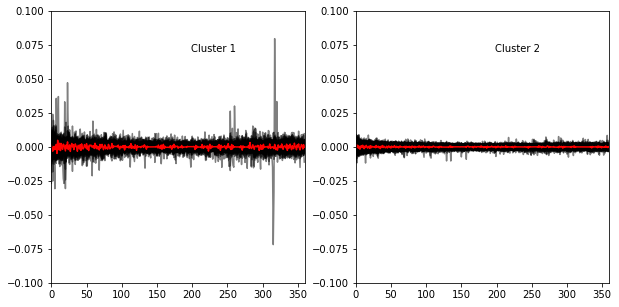

In [88]:
plt.figure(figsize=(10, 5))
for yi in range(2):
    plt.subplot(1, 2, yi + 1)
    for xx in df_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.5)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, 360)
    plt.ylim(-0.1, 0.1)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    plt.savefig("/Users/luzhang/Desktop/wrap up/AMZN_regime.pdf", format = "pdf")

In [117]:
data_labels = labels.items()
data_list = list(data_labels)

df_labels = pd.DataFrame(data_list)
df_labels.columns=['datetime','regime']
df_labels = df_labels.set_index('datetime')

In [121]:
df_labels.index = df_labels.index.str.rstrip()

In [135]:
df_merged = pd.read_csv("/Users/luzhang/Documents/GitHub/WrappingUp_Exploring_Intraday_Momentum_2rd_try/Data/AMZN_Returns_updates.csv")

In [137]:
df_merged = df_merged.set_index("datetime")

In [138]:
df_merged.index

Index(['2008-01-03', '2008-01-04', '2008-01-07', '2008-01-08', '2008-01-09',
       '2008-01-10', '2008-01-11', '2008-01-14', '2008-01-15', '2008-01-16',
       ...
       '2018-05-17', '2018-05-18', '2018-05-21', '2018-05-22', '2018-05-23',
       '2018-05-24', '2018-05-25', '2018-05-29', '2018-05-30', '2018-05-31'],
      dtype='object', name='datetime', length=2601)

In [139]:
new_data = pd.merge(df_merged, df_labels, on="datetime", how = "inner")

In [141]:
new_data.to_csv("/Users/luzhang/Documents/GitHub/WrappingUp_Exploring_Intraday_Momentum_2rd_try/Data/AMZN_Returns_with_regime.csv", index = True)

## Backward Linear Regression

In [60]:
returns = pd.read_csv("/Users/luzhang/Documents/GitHub/WrappingUp_Exploring_Intraday_Momentum_2rd_try/Data/NVDA_nscoreReturns.csv")

In [61]:
returns.head()

,R_LH,R_LH0,R_ROD,R_ON,R_FH,R_ONFH,R_M,R_SLH
0,0.989237,-0.818603,-0.807677,-0.483500,0.663580,0.216674,-1.403715,1.055423
1,-1.728742,0.989237,0.092145,1.073870,0.503202,1.083232,-0.987816,-0.093021
2,-0.536145,-1.732642,0.543208,1.406055,-0.538160,0.766074,0.341897,-1.084801
3,0.259747,-0.538160,-0.691006,0.431206,-0.441759,-0.074640,-0.572762,-1.401383
4,-1.138180,0.259747,1.029889,0.870942,0.717833,1.073870,0.481541,-0.077264


In [62]:
y = returns.R_LH

In [63]:
X = returns[returns.columns[1:8]]

In [64]:
lr_full = sm.OLS(y,X).fit()

In [65]:
lr_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   R_LH   R-squared (uncentered):                   0.012
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              4.904
Date:                Fri, 06 Oct 2023   Prob (F-statistic):                    1.61e-05
Time:                        11:45:19   Log-Likelihood:                         -4060.2
No. Observations:                2874   AIC:                                      8134.
Df Residuals:                    2867   BIC:                                      8176.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
R_LH0         -0.0656      0.019     -3.523      0.000      -0.102      -0.029
R_ROD          0.0710      0.105      0.676      0.499      -0.135       0.277
R_ON           0.0759      0.064      1.182      0.237      -0.050       0.202
R_FH           0.0306      0.065      0.468      0.640      -0.098       0.159
R_ONFH        -0.0793      0.105     -0.758      0.449      -0.285       0.126
R_M            0.0162      0.072      0.226      0.821      -0.124       0.156
R_SLH         -0.0204      0.026     -0.781      0.435      -0.071       0.031
==============================================================================
Omnibus:                        0.156   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.925   Jarque-Bera (JB):                0.204
Skew:                           0.002   Prob(JB):                        0.903
Kurtosis:                       2.959   Cond. No.                         13.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""